Code for phosphoproteomics graphs

In [1]:
import pandas
import urllib3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from pandas.plotting import _converter
from matplotlib.pyplot import figure

# richard

In [2]:
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
engine=create_engine("sqlite:///1.7 -funtional.db")#,echo=True)
Session=sessionmaker(bind=engine)
session=Session()

from sqlalchemy import MetaData, Table
metadata = MetaData()
alt_names=Table('Alt_names', metadata, autoload=True, autoload_with=engine)
inhibitor=Table('Inhibitor',metadata,autoload=True,autoload_with=engine)
kinase=Table('Kinase',metadata,autoload=True,autoload_with=engine)
kinase_inhibitor=Table('Kinase_Inhibitor',metadata,autoload=True,autoload_with=engine)
sub_phos=Table('Substrate_phosphosite',metadata,autoload=True,autoload_with=engine)
substrate_kinase=Table('Substrate_site_Kinase',metadata,autoload=True,autoload_with=engine)
substrate=Table('Substrate',metadata,autoload=True,autoload_with=engine)

C:\Users\44771\Anaconda3\lib\site-packages\sqlalchemy\dialects\sqlite\base.py:1297: SAWarning: Could not instantiate type <class 'sqlalchemy.sql.sqltypes.INTEGER'> with reflected arguments ['3']; using no arguments.
  (coltype, args))
C:\Users\44771\Anaconda3\lib\site-packages\sqlalchemy\dialects\sqlite\base.py:1297: SAWarning: Could not instantiate type <class 'sqlalchemy.sql.sqltypes.INTEGER'> with reflected arguments ['7']; using no arguments.
  (coltype, args))
C:\Users\44771\Anaconda3\lib\site-packages\sqlalchemy\dialects\sqlite\base.py:1297: SAWarning: Could not instantiate type <class 'sqlalchemy.sql.sqltypes.INTEGER'> with reflected arguments ['5']; using no arguments.
  (coltype, args))


In [4]:
filename = "az20.tsv"

info=pandas.read_csv(filename, sep="\t")
#tsv file, read as table, default is tab separated so no need for sep="\t"

info=info.dropna(axis=1, how='all') 
#drop all columns where all elements are "NaNs"- when table was exported, some columns contained all NaNs

info=info.dropna() 
#still some NaNs in df. Drop all rows that have at least one "NaN" (empty cell)

info.columns = info.columns.str.strip().str.lower().str.replace('(', '').str.replace(')', '') #.str.replace('-', '_')
#remove all white space in column names, make all strings lower case, remove brackets
#info
for x in info.columns.values:
    if "fold" in x:
        a="fold_change"
        info.columns = info.columns.str.replace(x,a)
    if "value" in x:
        b="p-value"
        info.columns = info.columns.str.replace(x,b)
    if "ctrlcv" in x:
        c="ctrlcv"
        info.columns = info.columns.str.replace(x,c)
    if "treatcv" in x:
        d="treatcv"
        info.columns = info.columns.str.replace(x,d)
    if "mean" in x and "control" not in x:
        e="treatment_mean"
        info.columns = info.columns.str.replace(x,e)
        
info[:5]

,substrate,control_mean,treatment_mean,fold_change,p-value,ctrlcv,treatcv
0,1A24_HUMAN(S356),1.527934e+07,2.643439e+07,1.730074,0.554298,1.280092,0.902944
1,1A24_HUMAN(S359),1.527934e+07,2.643439e+07,1.730074,0.554298,1.280092,0.902944
2,1B13_HUMAN(None),2.706473e+07,2.779116e+07,1.026841,0.962084,0.724637,0.580207
3,1B39_HUMAN(M1),1.158130e+09,1.173595e+09,1.013353,0.958301,0.128036,0.399220
4,1B39_HUMAN(M4),1.158130e+09,1.173595e+09,1.013353,0.958301,0.128036,0.399220


In [5]:
info=info[~info['substrate'].str.contains("None")] 
#removes all substrates with no reported phosphosite in the dataset (invert (~) operator acts like a 'not' for boolean data)

info=info[~info['substrate'].str.contains("\(M")] 
#remove all methionines -regex

info['log2_fold_change'] = np.log2(info['fold_change'])
#log 2 of fold change 

info['-log10(pvalue)'] = np.log10(info['p-value'])
info.loc[:, '-log10(pvalue)'] = info['-log10(pvalue)'] * -1
#-log10 of pvalue 

info[:5]
#get log2 of the fold change and -log10 of pvalue and make volcanoe plot 

,substrate,control_mean,treatment_mean,fold_change,p-value,ctrlcv,treatcv,log2_fold_change,-log10(pvalue)
0,1A24_HUMAN(S356),1.527934e+07,2.643439e+07,1.730074,0.554298,1.280092,0.902944,0.790834,0.256257
1,1A24_HUMAN(S359),1.527934e+07,2.643439e+07,1.730074,0.554298,1.280092,0.902944,0.790834,0.256257
7,AAAS(S495),3.886162e+09,4.023860e+09,1.035433,0.798476,0.118671,0.190204,0.050234,0.097738
9,AAGAB(S310),1.237204e+07,5.187831e+06,0.419319,0.532084,1.332381,1.732051,-1.253880,0.274020
10,AAGAB(S311),1.398521e+07,5.187831e+06,0.370951,0.427256,1.106864,1.732051,-1.430698,0.369312


Phosphosites are deemed significantly up- or down-regulated if they have
an adjusted p-value less than or equal to 0.05 
with a fold-change greater than 1.5 (upregulated) or less than -1.5 (downregulated).
Significant fold change values are represented by the red color in the plot below, whereas 
non-significant ones are displayed in blue.
The volcano plot depicts the -log of P-value vs the log2 fold change of each phosphosite.
The plot below displays data points representing all the phosphosites from the given dataset.


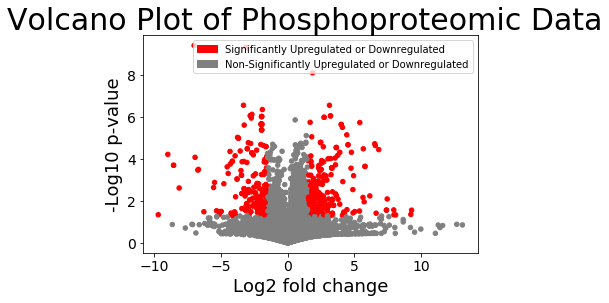

In [6]:
import matplotlib.patches as mpatches
colours = np.where((info["log2_fold_change"]<-1.5) & (info["-log10(pvalue)"]>1.301) | (info["log2_fold_change"]>1.5) & (info["-log10(pvalue)"]>1.301)  ,'red', 'grey')

# colour code for all points where log 2 fold change is greater than 1 (upregulated) AND pvalue is less than 0.05 OR 
# fold change is less than -1 AND p value is less than 0.05 

# threshold for p value is 0.05 -> -log10 of 0.05 is 1.301 -> anything above 1.301 is significant

# threshold for log2 fold change is over 1 and under -1. 


txt = '''Volcano plot to show phosphoproteomic data. Points represent the 
fold change of each phosphosite. Red circles show 
phosphosites that have significant increases or decreases.
Grey dots represent kinases that show no difference. 
The y axis shows the -log 10 transformation of the statsitical significance for each phosphosite'''


info.plot.scatter(x='log2_fold_change', y='-log10(pvalue)', c=colours) #assign x and y axis and colours of points

rcParams['figure.figsize'] = 18, 10 #figure size

plt.suptitle('Volcano Plot of Phosphoproteomic Data', fontsize=30) #title

plt.xlabel("Log2 fold change", fontsize=18) #font size of x axis label

plt.ylabel("-Log10 p-value", fontsize=18) #font size of y axis label

plt.xticks(fontsize=14) #font size of x ticks

plt.yticks(fontsize=14) #font size of y ticks
red_dots = mpatches.Patch(color='red', label='Significantly Upregulated or Downregulated')
grey_dots=mpatches.Patch(color='grey', label='Non-Significantly Upregulated or Downregulated')
patches=[red_dots,grey_dots]
plt.legend(handles=patches)

#Volcano plots showing the magnitude and significance of differential phosphopeptide abundance 
#in az20-stimulated versus unstimulated cells. 
number=len(info["log2_fold_change"])
print ("""Phosphosites are deemed significantly up- or down-regulated if they have
an adjusted p-value less than or equal to 0.05 
with a fold-change greater than 1.5 (upregulated) or less than -1.5 (downregulated).
Significant fold change values are represented by the red color in the plot below, whereas 
non-significant ones are displayed in blue.
The volcano plot depicts the -log of P-value vs the log2 fold change of each phosphosite.
The plot below displays data points representing all the phosphosites from the given dataset.""")

In [7]:
info_=info[info["p-value"] <= 0.05]
#dataframe containing data only for when the p-value is less than or equal to 0.05(threshold)

In [8]:
info2=info_.sort_values(by=['log2_fold_change'],ascending=False) #sort values - largest to smallest
info3=info_.sort_values(by=['log2_fold_change'],ascending=True) #sort values - smallest to largest
info4 = info2.drop(info2.index[40:],axis=0) #take top 40 of largest values of logFC
info5 = info3.drop(info3.index[40:],axis=0) #take top 40 of smallest (most negative) values of logFC

The phosphosites are treated with a kinase inhibitor and
the change in average peak area is exhibited as log2 fold change per phosphosite.
The bar chart below shows significant change in log2 fold change for p-value less than or equal to 0.05 
in terms of upregulated change (+ve log2 FC), in other words, mean peak area of treatment is more than control.
The plot below displays top 40 positive log2 fold change of the phosphosites from the given dataset.


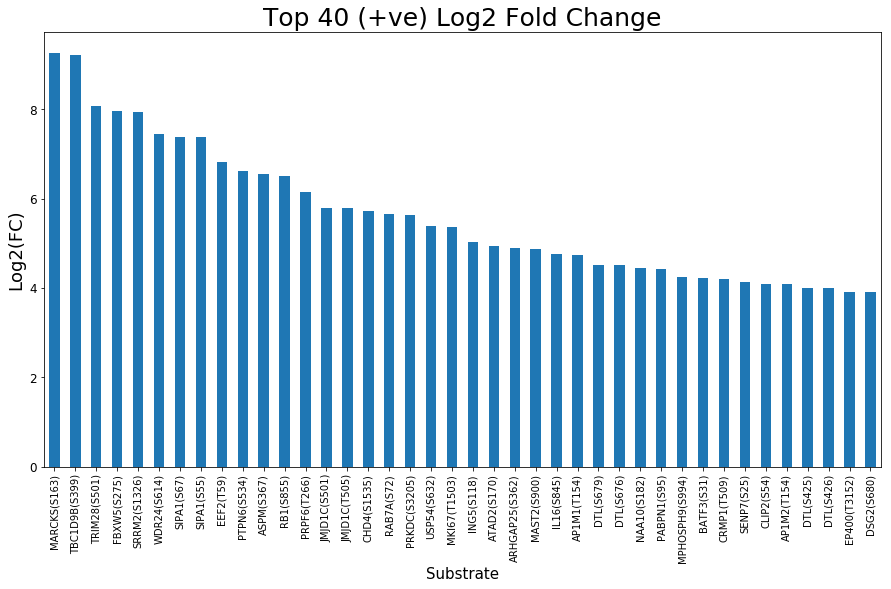

In [9]:
labels1=info4["substrate"]
df = pandas.DataFrame({"substrate":info4["substrate"], 'LogFC': info4["log2_fold_change"]})
plt.rcParams["figure.figsize"] =(15,8)
info2=info.sort_values(by=['log2_fold_change'],ascending=False) #sort values - largest to smallest

info3=info.sort_values(by=['log2_fold_change'],ascending=True) #sort values - smallest to largest
info4 = info2.drop(info2.index[40:],axis=0) #take top 40 of largest values of logFC
info5 = info3.drop(info3.index[40:],axis=0) #take top 40 of smallest (most negative) values of logFC
plt.rcParams.update({'font.size': 15})
ax = df.plot.bar(rot=0) 
ax.tick_params(labelsize=6)
ax.set_xticklabels(labels1, rotation=0)
ax.set_title("Top 40 (+ve) Log2 Fold Change", fontsize=25)
#ax.autoscale(tight=True)
plt.xticks(rotation=90) 
plt.xticks(fontsize=10)
plt.yticks(fontsize=12)
plt.xlabel('Substrate')
plt.ylabel('Log2(FC)', fontsize=18)
ax.legend().set_visible(False)  #to remove legend
print ("""The phosphosites are treated with a kinase inhibitor and
the change in average peak area is exhibited as log2 fold change per phosphosite.
The bar chart below shows significant change in log2 fold change for p-value less than or equal to 0.05 
in terms of upregulated change (+ve log2 FC), in other words, mean peak area of treatment is more than control.
The plot below displays top 40 positive log2 fold change of the phosphosites from the given dataset.""")
    

The phosphosites are treated with a kinase inhibitor and
the change in average peak area is exhibited as log2 fold change per phosphosite.
The bar chart below shows significant change in log2 fold change for p-value less than or equal to 0.05 
in terms of upregulated change (-ve log2 FC), in other words, mean peak area of treatment is less than control.
The plot below displays top 40 negative log2 fold change of the phosphosites from the given dataset.


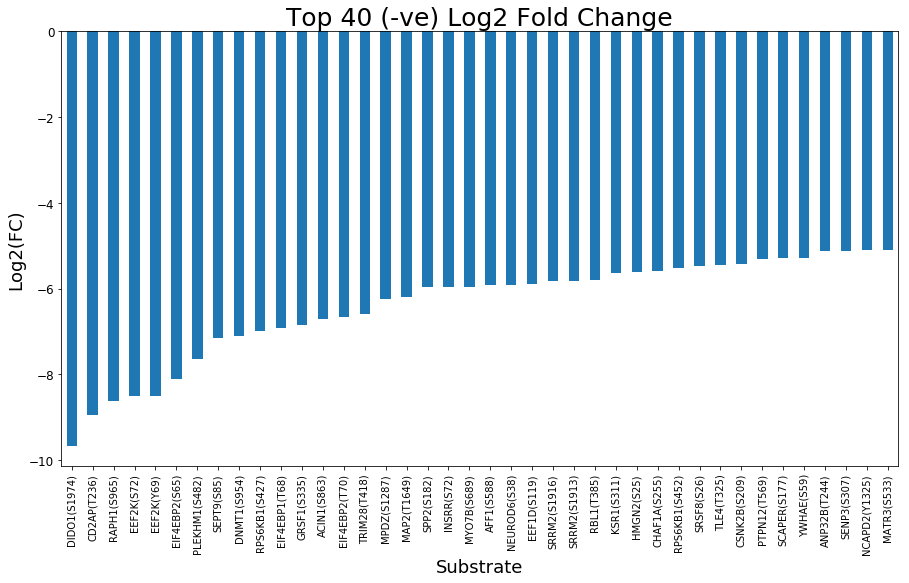

In [10]:
labels2=info5["substrate"]
df = pandas.DataFrame({"substrate":info5["substrate"], 'LogFC': info5["log2_fold_change"]})
plt.rcParams["figure.figsize"] =(15,8)
plt.rcParams.update({'font.size': 15})
ax = df.plot.bar(rot=0) 
ax.tick_params(labelsize=6)
ax.set_xticklabels(labels2, rotation=0)
ax.set_title("Top 40 (-ve) Log2 Fold Change", fontsize=25)
#ax.autoscale(tight=True)
plt.xticks(rotation=90) 
plt.xticks(fontsize=10)
plt.yticks(fontsize=12)
plt.xlabel('Substrate', fontsize=18)
plt.ylabel('Log2(FC)', fontsize=18)
ax.legend().set_visible(False)  #to remove legend
print ("""The phosphosites are treated with a kinase inhibitor and
the change in average peak area is exhibited as log2 fold change per phosphosite.
The bar chart below shows significant change in log2 fold change for p-value less than or equal to 0.05 
in terms of upregulated change (-ve log2 FC), in other words, mean peak area of treatment is less than control.
The plot below displays top 40 negative log2 fold change of the phosphosites from the given dataset.""")

# ADD 

In [12]:
kinasedat={}
for kn in info.substrate:
    kinlist=[]
    kn=kn.split("(")
    kn[1]=kn[1][:-1]
    subs=kn[0]
    modres=kn[1]
    try:
        kname=session.query(sub_phos).filter(sub_phos.c.Modified_residue==modres,sub_phos.c.Substrate_name==subs).one()
        kin=session.query(substrate_kinase).filter(substrate_kinase.c.Substrate_kinase_ID==kname.Substrate_kinase_ID).all()
        for x in kin:
            if x.Kinase_name not in kinlist:
                kinlist.append(x.Kinase_name)
        kinasedat[subs+"("+modres+")"]=kinlist
    except:
            try:
                sname=session.query(substrate).filter(substrate.c.Substrate_gene_name==subs).one()
                kname=session.query(sub_phos).filter(sub_phos.c.Modified_residue==modres,sub_phos.c.Substrate_name==sname.Substrate_name).one()
                kin=session.query(substrate_kinase).filter(substrate_kinase.c.Substrate_kinase_ID==kname.Substrate_kinase_ID).all()
                for x in kin:
                    if x.Kinase_name not in kinlist:
                        kinlist.append(x.Kinase_name)
                kinasedat[subs+"("+modres+")"]=kinlist
            except:
                pass

In [13]:
kinaselist_df=pandas.DataFrame(list(kinasedat.items()),columns=['substrate','Kinase']) 
kinaselist_df

,substrate,Kinase
0,AAK1(T389),[CDK1]
1,ABCF1(S109),[CK2A1]
2,ABCF1(S140),[CK2A1]
3,ABI1(S183),"[ERK1, ERK2]"
4,ABI1(Y213),[Abl]
5,ACACA(S80),"[AMPKA1, AMPKA2]"
6,ADD1(S12),[CDK1]
7,ADD1(S726),"[Chk1, PKCA, PKCD, PKCZ]"
8,ADD2(S613),[GSK3B]
9,ADD2(S701),[CDK5]


In [14]:
merged_info=pandas.merge(info,kinaselist_df, how="inner", on =["substrate"])
merged_info

,substrate,control_mean,treatment_mean,fold_change,p-value,ctrlcv,treatcv,log2_fold_change,-log10(pvalue),Kinase
0,AAK1(T389),3.220931e+08,2.678659e+08,0.831641,0.572706,0.339347,0.423268,-0.265967,0.242068,[CDK1]
1,ABCF1(S109),3.729907e+09,5.887469e+09,1.578449,0.024749,0.184789,0.178244,0.658508,1.606443,[CK2A1]
2,ABCF1(S140),5.130510e+09,3.859859e+09,0.752334,0.171288,0.209021,0.239829,-0.410554,0.766272,[CK2A1]
3,ABI1(S183),6.954255e+09,8.002003e+09,1.150663,0.274058,0.131522,0.149789,0.202465,0.562157,"[ERK1, ERK2]"
4,ABI1(Y213),3.553320e+08,4.794626e+08,1.349337,0.121853,0.043769,0.246919,0.432251,0.914164,[Abl]
5,ACACA(S80),9.367416e+08,1.819075e+09,1.941918,0.006910,0.140979,0.195626,0.957482,2.160533,"[AMPKA1, AMPKA2]"
6,ADD1(S12),3.122984e+07,5.593549e+07,1.791091,0.446615,1.001082,0.755225,0.840839,0.350066,[CDK1]
7,ADD1(S726),1.332489e+07,1.949857e+07,1.463319,0.641231,0.726807,1.001791,0.549244,0.192985,"[Chk1, PKCA, PKCD, PKCZ]"
8,ADD2(S613),1.747978e+09,3.721304e+08,0.212892,0.007357,0.312763,0.664823,-2.231807,2.133321,[GSK3B]
9,ADD2(S701),4.655196e+08,4.234087e+08,0.909540,0.928164,1.435194,0.931672,-0.136791,0.032375,[CDK5]


# Fabrizio

In [26]:
newDF=pandas.DataFrame(columns=["substrate","control_mean","treatment_mean","fold_change","p-value","ctrlcv","treatcv","log2_fold_change","-log10(pvalue)","protein_modres","Kinase"])
count=0
for (i,row) in merged_info.iterrows():
    for kin in row['Kinase']:
        newDF.loc[count]=row
        newDF.loc[count,'Kinase']=kin
        count+=1
newDF

,substrate,control_mean,treatment_mean,fold_change,p-value,ctrlcv,treatcv,log2_fold_change,-log10(pvalue),protein_modres,Kinase
0,AAK1(T389),3.220931e+08,2.678659e+08,0.831641,0.572706,0.339347,0.423268,-0.265967,0.242068,NaN,CDK1
1,ABCF1(S109),3.729907e+09,5.887469e+09,1.578449,0.024749,0.184789,0.178244,0.658508,1.606443,NaN,CK2A1
2,ABCF1(S140),5.130510e+09,3.859859e+09,0.752334,0.171288,0.209021,0.239829,-0.410554,0.766272,NaN,CK2A1
3,ABI1(S183),6.954255e+09,8.002003e+09,1.150663,0.274058,0.131522,0.149789,0.202465,0.562157,NaN,ERK1
4,ABI1(S183),6.954255e+09,8.002003e+09,1.150663,0.274058,0.131522,0.149789,0.202465,0.562157,NaN,ERK2
5,ABI1(Y213),3.553320e+08,4.794626e+08,1.349337,0.121853,0.043769,0.246919,0.432251,0.914164,NaN,Abl
6,ACACA(S80),9.367416e+08,1.819075e+09,1.941918,0.006910,0.140979,0.195626,0.957482,2.160533,NaN,AMPKA1
7,ACACA(S80),9.367416e+08,1.819075e+09,1.941918,0.006910,0.140979,0.195626,0.957482,2.160533,NaN,AMPKA2
8,ADD1(S12),3.122984e+07,5.593549e+07,1.791091,0.446615,1.001082,0.755225,0.840839,0.350066,NaN,CDK1
9,ADD1(S726),1.332489e+07,1.949857e+07,1.463319,0.641231,0.726807,1.001791,0.549244,0.192985,NaN,Chk1


# p - mean log2 fold change of ALL phosphosites in dataset

In [13]:
mean_log2_fold_change=newDF.loc[:,"log2_fold_change"].mean()
p=mean_log2_fold_change
p

0.1402563558364485

# δ - standard deviation of log2 fold change across ALL phosphosites in dataset
### (whether or not they have a known kinase?)

In [14]:
#δ is standard deviation of log2 fold change across ALL phosphosites in dataset
sd_log2_fold_change=newDF.loc[:,"log2_fold_change"].std()
sigma=sd_log2_fold_change
sigma

1.2230855654013015



# m - total number of phosphosites that map to that kinase (total number of times kinase shows in df as a match)



In [15]:
m=newDF.groupby('Kinase').size()
m=m.to_dict()
m

{'AAK1': 1,
 'AMPKA1': 7,
 'ARAF': 2,
 'ATM': 9,
 'ATR': 3,
 'Abl': 1,
 'Akt1': 25,
 'Akt2': 4,
 'Akt3': 1,
 'AurA': 3,
 'AurB': 13,
 'BRAF': 3,
 'BRSK1 iso2': 1,
 'BRSK2': 1,
 'BUB1': 2,
 'CAMK1A': 1,
 'CAMK1B': 1,
 'CAMK1G': 1,
 'CAMK2A': 4,
 'CAMK2B': 1,
 'CAMK2D iso8': 1,
 'CAMK2G': 1,
 'CAMK4': 1,
 'CDC7': 9,
 'CDK1': 92,
 'CDK14': 2,
 'CDK19': 1,
 'CDK2': 79,
 'CDK20': 1,
 'CDK4': 4,
 'CDK5': 6,
 'CDK6': 1,
 'CDK7': 8,
 'CDK9': 2,
 'CK1A': 1,
 'CK1D': 1,
 'CK1G2': 1,
 'CK2A1': 35,
 'CK2A2': 1,
 'Chk1': 23,
 'Chk2': 2,
 'Cot': 3,
 'DAPK1': 2,
 'DAPK3': 1,
 'DYRK1A': 4,
 'DYRK2': 3,
 'ERK1': 22,
 'ERK2': 23,
 'ERK5': 1,
 'GRK6': 1,
 'GSK3A': 4,
 'GSK3B': 9,
 'GTF2F1': 2,
 'HER2': 1,
 'HIPK1': 2,
 'HIPK2': 11,
 'IKKA': 1,
 'IKKB': 1,
 'IRAK1': 1,
 'JNK1': 8,
 'JNK2': 1,
 'JNK2 iso2': 1,
 'KIS': 3,
 'LOK': 1,
 'Lmr2': 1,
 'MAPKAPK2': 7,
 'MARK2': 4,
 'MEK1': 1,
 'MEKK1': 1,
 'MEKK2': 1,
 'MELK': 5,
 'MKK7': 1,
 'MST2': 1,
 'Myt1': 2,
 'NEK2': 1,
 'NEK6': 1,
 'NEK9': 1,
 'NME1': 1,
 '

# s - mean of log2 fold change of all substrates of the kinase in question

In [16]:
s_df=pandas.DataFrame({"Kinase":newDF["Kinase"],"log2FC":newDF["log2_fold_change"]})
newdic={}
for x in s_df.values:
    if x[0] not in newdic:
        newdic[x[0]]=x[1]
    elif x[0] in newdic:
        newdic[x[0]]+=x[1]
print(newdic)

{'CDK1': 18.47796363744361, 'CK2A1': 12.151179941324115, 'Chk1': 5.264779501151291, 'PKCA': 9.865548844480129, 'PKCD': 7.308593288616881, 'PKCZ': 0.964764102514234, 'GSK3B': 4.261617853038032, 'CDK5': -1.288062279833438, 'Akt3': -0.4017256663618948, 'MAPKAPK2': -0.43808568567857575, 'PKACA': 2.703758597439338, 'CDK2': 11.149810508804167, 'mTOR': -10.859879748404806, 'AAK1': -0.2942851018262246, 'Akt1': -12.471649552570899, 'ROCK1': 0.08369816814957855, 'MARK2': 4.837042076187249, 'PAK1': 2.824220171696715, 'PKCT': 4.055693586491518, 'PKG1': 0.8423463964410116, 'PKCG': 0.44406241970573923, 'ERK1': 8.642016409475652, 'ERK2': 7.589119269231044, 'ATM': -0.3657934907100365, 'ARAF': -0.7379322412116043, 'BRAF': -0.29375574227869045, 'PKCE': -0.3199999311798072, 'PKCI': 0.17765769234641693, 'PRKD1': 1.8953928445677357, 'RAF1': -0.7379322412116043, 'RSK2': 1.5924283704806854, 'Src': -0.24989804225676335, 'AMPKA1': 5.039061172756053, 'ATR': -1.1233252912180005, 'TTK': 1.3597696213438857, 'p70S6

In [17]:
s_dictvalues={k:newdic[k]/m[k] for k in newdic.keys() & m}
print (s_dictvalues)

{'P38D': 0.31781425612802694, 'IKKB': -0.3749712882253135, 'CDK7': 0.289611952754018, 'CAMK2G': 0.35438026326274064, 'ROCK1': 0.041849084074789274, 'P38G': 0.14075857078015455, 'SGK3': -0.0633224678647135, 'PLK1': 0.48261497709129997, 'CK2A1': 0.3471765697521176, 'ATM': -0.040643721190004055, 'CAMK1B': 0.05715872301536543, 'P70S6KB': -0.0633224678647135, 'Src': -0.04997960845135267, 'SRPK1': -0.07834882874716663, 'CDK1': 0.2008474308417784, 'RAF1': -0.36896612060580214, 'CDK9': 1.009430255972361, 'CDK6': -3.5357360453407503, 'AurB': -0.07601141152987854, 'AMPKA1': 0.7198658818222933, 'Lmr2': 0.5035530053056071, 'PKCT': 1.0139233966228796, 'LOK': 1.1789179845488433, 'ATR': -0.3744417637393335, 'RIPK2': 0.9513549889069127, 'MEK1': 3.579626093101647, 'Akt3': -0.4017256663618948, 'NEK2': -0.2257452278332779, 'GTF2F1': 1.0640449838644865, 'TTK': 0.4532565404479619, 'GRK6': 5.7017643392730415, 'JNK1': 0.16326784284617085, 'BRAF': -0.09791858075956349, 'CDK19': -1.9701265962410934, 'CAMK2B': 

# z-score

In [18]:
import math
n=math.sqrt(4)
z=(5-6)*n/(sigma)
zscore={}
for x in s_dictvalues.keys():
    if x in m.keys():
        n=math.sqrt(int(m[x]))
        z=(s_dictvalues[x]-p)*n/(sigma)
        zscore[x]=z

        
zscore_df=pandas.DataFrame(list(zscore.items()),columns=['Kinase','Relative Activity'])    

zscore_df
#zscore_df=pandas.Series(zscore).to_frame("Kinase")
#zscore_df=pandas.DataFrame.from_dict(zscore,index=zscore.keys(), header=None, columns= ["Kinase","Relative Kinase Activity"])

,Kinase,Relative Activity
0,P38D,0.290344
1,IKKB,-0.421252
2,CDK7,0.345390
3,CAMK2G,0.175069
4,ROCK1,-0.113785
5,P38G,0.000581
6,SGK3,-0.166447
7,PLK1,0.791716
8,CK2A1,1.000876
9,ATM,-0.443714


In [19]:
zscore2_df=zscore_df.sort_values(by=['Relative Activity'],ascending=False) #sort values - largest to smallest
zscore3_df=zscore_df.sort_values(by=['Relative Activity'],ascending=True) #sort values - smallest to largest
zscore4_df=zscore2_df.drop(zscore2_df.index[40:],axis=0) #take top 40 of largest values of relative kinase activity
zscore5_df=zscore3_df.drop(zscore3_df.index[40:],axis=0) #take top 40 of smallest (most negative) values of relative kinase activity

Text(0, 0.5, 'Relative Kinase Activity (Z-score)')

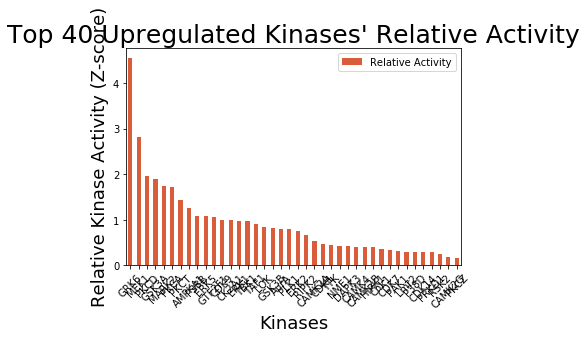

In [20]:
ax =zscore4_df.plot.bar(rot=0, color="#DA5D3B") 
plt.xticks(rotation=90)
plt.xticks(fontsize=10)
plt.yticks(fontsize=12)
plt.rcParams["figure.figsize"] =(15,8)
plt.rcParams.update({'font.size': 15})


ax.tick_params(labelsize=10)
ax.set_xticklabels(zscore4_df["Kinase"], rotation=45)
ax.set_title("Top 40 Upregulated Kinases' Relative Activity", fontsize=25)
plt.xlabel('Kinases', fontsize=18)
plt.ylabel('Relative Kinase Activity (Z-score)', fontsize=18)

Text(0, 0.5, 'Relative Kinase Activity (Z-score)')

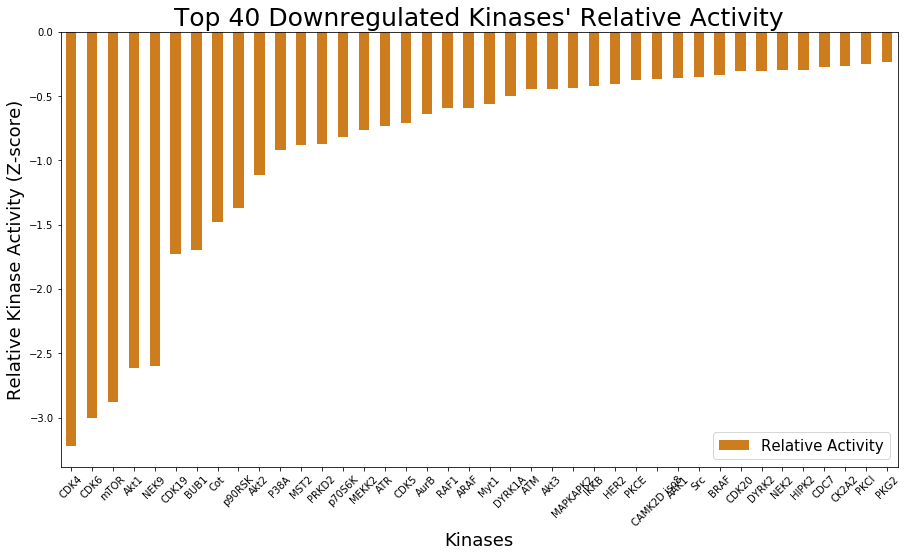

In [21]:
ax =zscore5_df.plot.bar(rot=0, color="#CD7C1E")
plt.xticks(rotation=90)
plt.xticks(fontsize=10)
plt.yticks(fontsize=12)
plt.rcParams["figure.figsize"] =(15,8)
plt.rcParams.update({'font.size': 15})
ax.tick_params(labelsize=10)
ax.set_xticklabels(zscore5_df["Kinase"], rotation=45)
ax.set_title("Top 40 Downregulated Kinases' Relative Activity", fontsize=25)
plt.xlabel('Kinases', fontsize=18)
plt.ylabel('Relative Kinase Activity (Z-score)', fontsize=18)

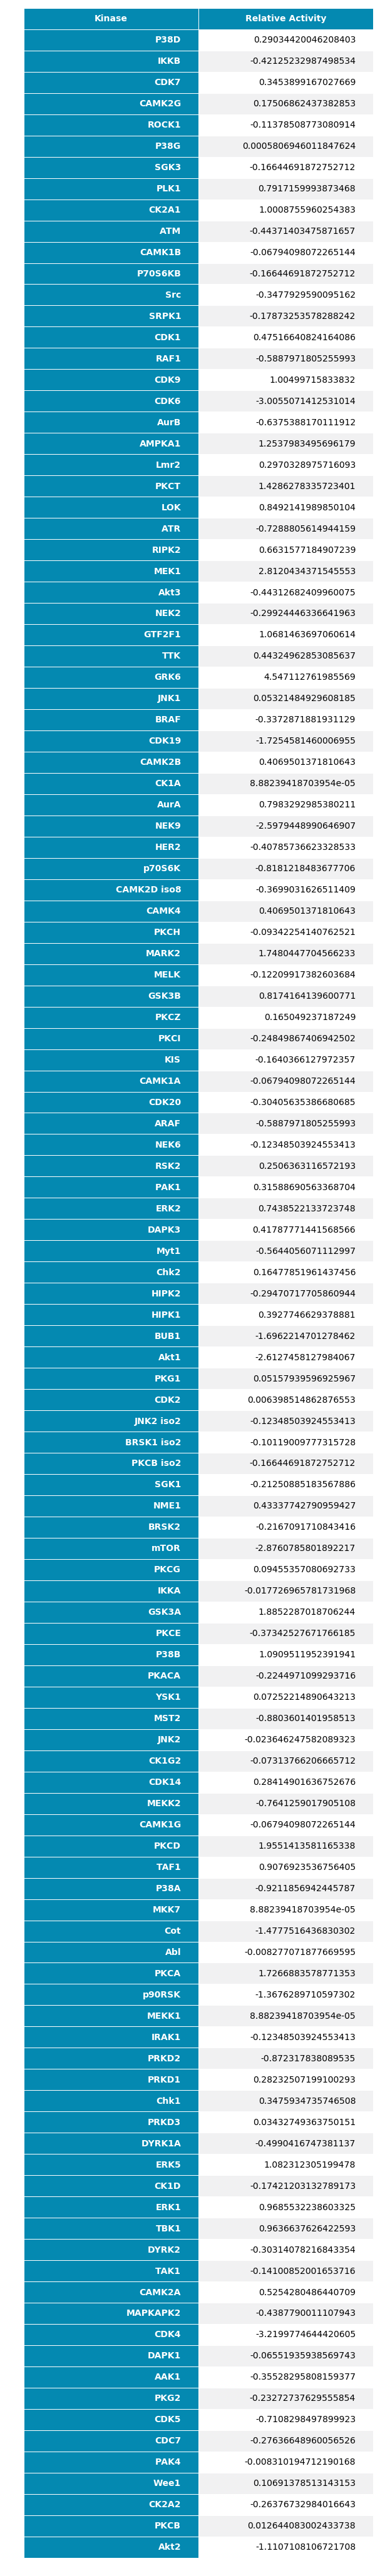

In [22]:
import six
def render_mpl_table(data, col_width=10.0, row_height=0.625, font_size=14,
                     header_color='#0489B1', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

render_mpl_table(zscore_df, header_columns=1, col_width=5.0)
#col_width changes column width

#tell browser page needs to be refreshed